## Prepare the workspace

In [1]:
# Before you proceed, update the PATH
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [1]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH.
# Updating to newest version of Torch due to error when using 1.0.0
!python -m pip install torch==2.1.2

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

import json

from collections import OrderedDict

import time

from PIL import Image

import matplotlib.pyplot as PLT

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
# Going to use the print function to confirm the naming.
data_dir = 'flowers'
print(data_dir)
training_dir = data_dir + '/train'
print(training_dir)
validation_dir = data_dir + '/valid'
print(validation_dir)
testing_dir = data_dir + '/test'
print(testing_dir)

flowers
flowers/train
flowers/valid
flowers/test


In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
# This section of code should transform the images using the information provided above
# For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]
# Adding three diffierent qualifiers training, validation, and testing. training_data_transforms for instance
# Adding random rotation to generate more robust model

training_transforms = transforms.Compose([transforms.RandomRotation (20),
                                              transforms.RandomResizedCrop(size=(300,600),
                                                                          scale=(0.4, 0.8)),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                              ])
#validation set
#validation set will use the same transform parameters as the training set
validation_transforms = transforms.Compose([transforms.RandomRotation (20),
                                              transforms.RandomResizedCrop(size=(300,600),
                                                                          scale=(0.4, 0.8)),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                              ])
#testing set
#testing set will use the same transform paramters as the training and validation set
testing_transforms = transforms.Compose([transforms.RandomRotation (20),
                                              transforms.RandomResizedCrop(size=(300,600),
                                                                          scale=(0.4, 0.8)),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                              ])
# TODO: Load the datasets with ImageFolder
training_data = datasets.ImageFolder(data_dir + '/train', transform=training_transforms)
print(training_data)
testing_data = datasets.ImageFolder(data_dir + '/test', transform=testing_transforms)
print(testing_data)
validation_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transforms)
print(validation_data)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# Setting batch size to 64 for each set and setting shuffle to true
train_loader = torch.utils.data.DataLoader(training_data, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size = 64, shuffle = True)

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: flowers/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(300, 600), scale=(0.4, 0.8), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 819
    Root location: flowers/test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(300, 600), scale=(0.4, 0.8), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
        # printing json to file to make sure all the flower names are present
    print(cat_to_name)

no_output_categories = len(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
# TODO: Build and train your network
# The link for the pre-trained network is dead. Googling PyTorch and VGG though brings up VGG16 
# pre-trained network VGG16 will be used

# Having some issues with models being recognized as torchvision.models so importing torchvision.model as models
import torchvision.models as models

# VGG16 will use 4096 hidden units for a fully connected first layer
hidden_units = 4096

# As indicated above VGG16 will be used
# UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
model = models.vgg16_bn(weights=True)

# The weights of the pretrained model will be frozen to limit data usage on the GPU network
for param in model.parameters():
    param.requires_grad = False

model.classifier


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]  


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
# Creating a new classifier for VGG16
# Replacing original classifier for requirements of this program
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, hidden_units)),
                          ('relU', nn.ReLU()),
                          ('dropout01', nn.Dropout(0.05)),
                          ('fch2', nn.Linear(hidden_units, no_output_categories)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

model.classifier


Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relU): ReLU()
  (dropout01): Dropout(p=0.05, inplace=False)
  (fch2): Linear(in_features=4096, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

In [9]:
# This will set the training parameters.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'The device in use is {device}.\n')

# Training parameters
# Epoch was originally set to 15 but this took too long. 80% confidence was established on 3 Epochs, dropped to 5 Epochs
epochs = 5
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()
print_every = 20

running_loss = running_accuracy = 0
validation_losses, training_losses = [], []

# Training process
for e in range(epochs):
    batches = 0
    model.train()
    
    for images, labels in train_loader:
        start = time.time()
        batches += 1

        # Move images to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass and calculate loss
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Metric calculation
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
        accuracy = matches.mean()

        # Metric tracker
        optimizer.zero_grad()
        running_loss += loss.item()
        running_accuracy += accuracy.item()

        # Model validation and printing metrics
        if batches % print_every == 0:
            end = time.time()
            training_time = end - start
            start = time.time()

            # Validation metrics
            validation_loss = 0
            validation_accuracy = 0

            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model.forward(images)
                    loss = criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
                    accuracy = matches.mean()

                    # Update validation metrics
                    validation_loss += loss.item()
                    validation_accuracy += accuracy.item()

            # Track training progress
            end = time.time()
            validation_time = end - start
            validation_losses.append(running_loss / print_every)
            training_losses.append(validation_loss / len(valid_loader))

            # Print metrics
            print(f'Epoch {e+1}/{epochs} | Batch {batches}')
            print(f'Running Training Loss: {running_loss / print_every:.3f}')
            print(f'Running Training Accuracy: {running_accuracy / print_every * 100:.2f}%')
            print(f'Validation Loss: {validation_loss / len(valid_loader):.3f}')
            print(f'Validation Accuracy: {validation_accuracy / len(valid_loader) * 100:.2f}%')

            # Reset metrics and turn on training mode
            running_loss = running_accuracy = 0
            model.train()



   

The device in use is cuda:0.

Epoch 1/5 | Batch 20
Running Training Loss: 5.405
Running Training Accuracy: 7.58%
Validation Loss: 3.965
Validation Accuracy: 17.64%
Epoch 1/5 | Batch 40
Running Training Loss: 3.314
Running Training Accuracy: 31.17%
Validation Loss: 2.679
Validation Accuracy: 42.46%
Epoch 1/5 | Batch 60
Running Training Loss: 2.293
Running Training Accuracy: 48.59%
Validation Loss: 1.796
Validation Accuracy: 59.96%
Epoch 1/5 | Batch 80
Running Training Loss: 1.618
Running Training Accuracy: 59.14%
Validation Loss: 1.421
Validation Accuracy: 64.93%
Epoch 1/5 | Batch 100
Running Training Loss: 1.327
Running Training Accuracy: 66.95%
Validation Loss: 1.082
Validation Accuracy: 71.92%
Epoch 2/5 | Batch 20
Running Training Loss: 1.104
Running Training Accuracy: 88.07%
Validation Loss: 0.976
Validation Accuracy: 74.22%
Epoch 2/5 | Batch 40
Running Training Loss: 0.804
Running Training Accuracy: 78.98%
Validation Loss: 0.839
Validation Accuracy: 79.30%
Epoch 2/5 | Batch 60
Runn

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
# TODO: Do validation on the test set
test_accuracy = 0

# Pring the time it will take 
start_time = time.time()
print('VGG16 Initialized.')

# Defines the test conditions
for images,labels in test_loader:
    model.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy

# Determine total time taken to perform
end_time = time.time()
print('Validation ended.')
validation_time = end_time - start_time
print('Validation time: {:.0f}m {:.0f}s'.format(validation_time / 60, validation_time % 60))
    
# Print the test accuracy. Target is ~70%
print(f'Test Accuracy: {test_accuracy/len(test_loader)*100:.2f}%')

VGG16 Initialized.
Validation ended.
Validation time: 1m 20s
Test Accuracy: 86.92%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# TODO: Save the checkpoint 
# saves the checkpoint 

# saves the checkpoint in the current directory
destination_directory = None
class_to_idx = training_data.class_to_idx # improves label to name mapping

# saves the model's state_dict
def save_model(trained_model,hidden_units,output_units,destination_directory,model_arch,class_to_idx):
    # defines model's checkpoint
    model_checkpoint = {'model_arch':model_arch, 
                    'clf_input':25088,
                    'clf_output':output_units,
                    'clf_hidden':hidden_units,
                    'state_dict':trained_model.state_dict(),
                    'model_class_to_index':class_to_idx,
                    }
    
    # saves model in current directory
    if destination_directory:
        torch.save(model_checkpoint,destination_directory+"/"+model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to {destination_directory}")
    else:
        torch.save(model_checkpoint,model_arch+"_checkpoint.pth")
        print(f"{model_arch} successfully saved to current directory as {model_arch}_checkpoint.pth")

# calls save_model
save_model(model,hidden_units,no_output_categories,destination_directory,'vgg16_bn',class_to_idx)

vgg16_bn successfully saved to current directory as vgg16_bn_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# writes a function that loads a checkpoint and rebuilds the model

# defines checkpoint as file created above
checkpoint = 'vgg16_bn_checkpoint.pth'

# function that accepts two arguments: filepath (location of checkpoint) and device(gpu/cpu)
def load_checkpoint(filepath,device):
    # loads the GPU when available
    if device=="gpu":
        map_location=lambda device, loc: device.cuda()
    else:
        map_location='cpu'
        # redefines checkpoint
    checkpoint = torch.load(f=filepath,map_location=map_location)

    # function returns number of input units, output units, hidden units, and state_dict
    return checkpoint['model_arch'],checkpoint['clf_input'], checkpoint['clf_output'], checkpoint['clf_hidden'],checkpoint['state_dict'],checkpoint['model_class_to_index']

# loads the checkpoint
model_arch,input_units, output_units, hidden_units, state_dict, class_to_idx = load_checkpoint(checkpoint,device)
model.load_state_dict(state_dict)


<All keys matched successfully>

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
# TODO: Process a PIL image for use in a PyTorch model
# Calling a sample image from the test assets
practice_flower = './flowers/test/100/image_07896.jpg'

def process_image(image):
    processed_image = Image.open(image).convert('RGB') 
    processed_image.thumbnail(size=(256,256))
    width, height = processed_image.size

    # Sets dimensions
    new_width,new_height = 224,224 
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    processed_image = processed_image.crop((left, top, right, bottom))

    # Converts to tensor using the transforms from the code above.
    transf_tens = transforms.ToTensor()
    transf_norm = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    tensor = transf_norm(transf_tens(processed_image))
    
    # Generate the numpy array
    np_processed_image = np.array(tensor)
    return np_processed_image
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
# Getting an undefined error in a later cell that seems to be related to plt. Adding in an import function. Similar issues with numpy it seems
# Continued to get mulitple errors from downstream check so modified code to accomodate
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    """Imshow for NumPy array."""
    if ax is None:
        fig, ax = plt.subplots()

    # Transpose dimensions to (height, width, channels)
    image = np.transpose(image, (1, 2, 0))

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    if title:
        ax.set_title(title)
    
    return ax

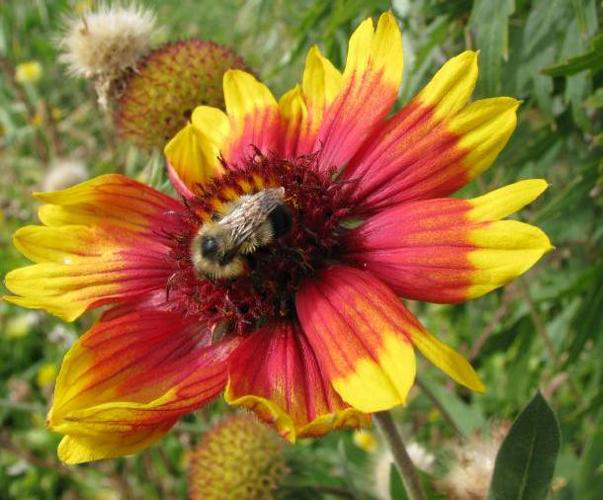

In [15]:
from PIL import Image

# Displaying image

processed_image = Image.open(practice_flower)
processed_image

<class 'str'>
<class 'numpy.ndarray'>


<Axes: >

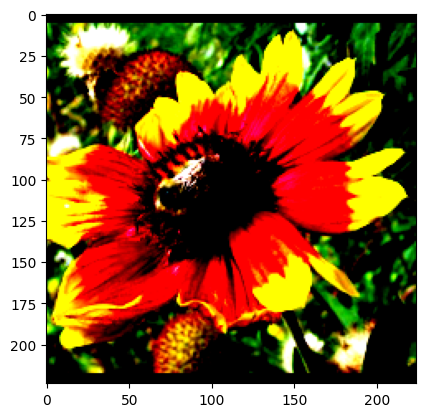

In [16]:
# Displaying the preprocessed image
print(type(practice_flower))
processed_image = process_image(practice_flower)
print(type(processed_image))
imshow(processed_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
import json

file = 'cat_to_name.json'

def class_to_label(file, classes):
    with open(file, 'r') as f:
        class_mapping = json.load(f)
        
    return [class_mapping[c] for c in classes]

idx_mapping = dict(map(reversed, class_to_idx.items()))

def predict(image_path, model, idx_mapping, topk, device):
    pre_processed_image = torch.from_numpy(process_image(image_path))
    pre_processed_image = torch.unsqueeze(pre_processed_image, 0).to(device).float()
    
    model.to(device).eval()
    
    log_ps = model.forward(pre_processed_image)
    ps, top_idx = torch.exp(log_ps).topk(topk, dim=1)
    
    classes = [idx_mapping[x] for x in top_idx.tolist()[0]]
    
    return ps.tolist()[0], classes

def print_predictions(probabilities, classes, image, category_names=None):
    print(image)
    
    labels = class_to_label(category_names, classes) if category_names else classes
    
    for i, (ps, ls, cs) in enumerate(zip(probabilities, labels, classes), 1):
        print(f'{i}) {ps * 100:.2f}% {ls.title()} | Class No. {cs}' if category_names else f'{i}) {ps * 100:.2f}% Class No. {cs}')
    
    print('') 

probabilities, classes = predict(practice_flower, model, idx_mapping, 5, device)
print_predictions(probabilities, classes, practice_flower.split('/')[-1], file)

    


    

image_07896.jpg
1) 98.59% Blanket Flower | Class No. 100
2) 1.37% Gazania | Class No. 71
3) 0.02% Osteospermum | Class No. 66
4) 0.01% Purple Coneflower | Class No. 17
5) 0.01% Black-Eyed Susan | Class No. 63



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

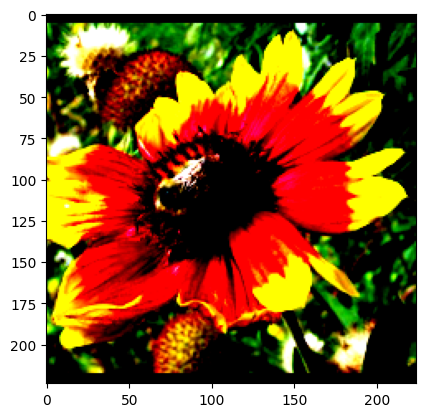

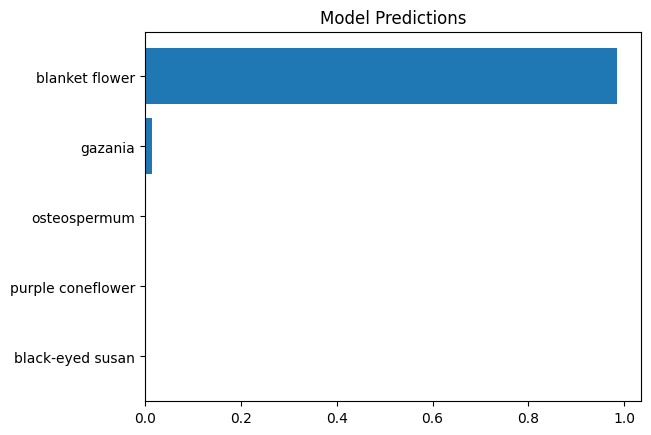

In [19]:
# TODO: Display an image along with the top 5 classes
# displays an image along with the top 5 classes
imshow(process_image(practice_flower))

# uses matplotlib for the task
plt.figure() # image
# defines probability axis
plt.barh(class_to_label(file,classes),width=probabilities)
plt.title('Model Predictions') # defines title
plt.gca().invert_yaxis() # defines y axis
plt.show() # shows diagram

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace